<a href="https://colab.research.google.com/github/andreac941/ComputerVision-Eq3/blob/main/4_convolution_vCarlos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import urllib.request

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__. 

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [ ]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [ ]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [ ]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros
    
    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

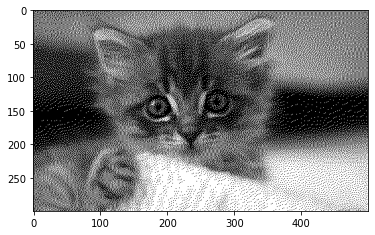

In [ ]:
urllib.request.urlretrieve(
  'https://placekitten.com/500/300',
   "image.jpg")
image = Image.open('image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

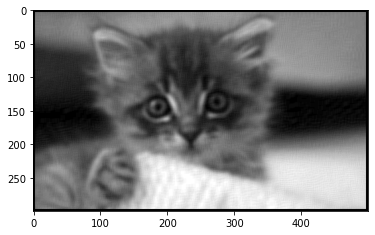

In [ ]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [ ]:
from PIL import Image

img = Image.open('image.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

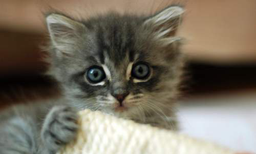

In [ ]:
img

In [ ]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [ ]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [ ]:
input = to_tensor(img)
input.shape


torch.Size([1, 154, 256])

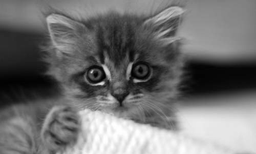

In [ ]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [ ]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [ ]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.0508, -0.0811, -0.0811,  ..., -0.0888, -0.0878, -0.0179],
         [-0.0405, -0.1242, -0.1242,  ..., -0.1381, -0.1372, -0.1774],
         [-0.0414, -0.1261, -0.1261,  ..., -0.1362, -0.1371, -0.1787],
         ...,
         [-0.0380, -0.1160, -0.1211,  ..., -0.2336, -0.2312, -0.3128],
         [-0.0346, -0.1143, -0.1180,  ..., -0.2200, -0.2235, -0.3113],
         [-0.0453,  0.0158,  0.0127,  ...,  0.0177,  0.0159, -0.1255]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [ ]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 154, 256])

In [ ]:
output = conv(input)
output.shape

torch.Size([1, 1, 154, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [ ]:
output.shape

torch.Size([1, 1, 154, 256])

We need to remove the first dimension before converting to a PIL object.

In [ ]:
output.data.squeeze(dim=0).shape

torch.Size([1, 154, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

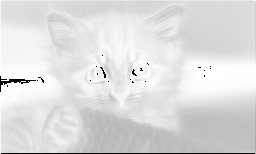

In [ ]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

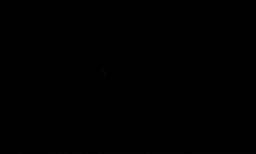

In [ ]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [ ]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

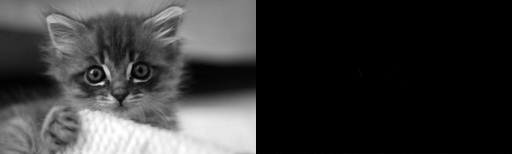

In [ ]:
display(input, output)

### Identity

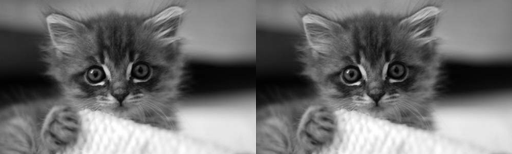

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


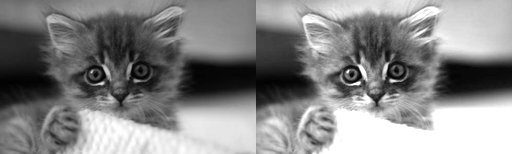

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


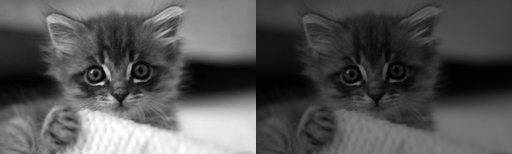

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


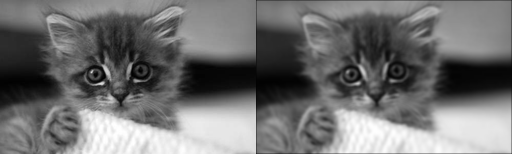

In [ ]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


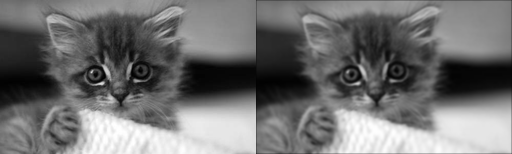

In [ ]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


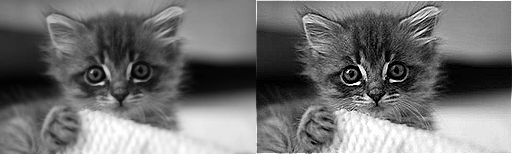

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


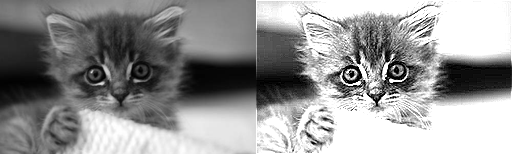

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


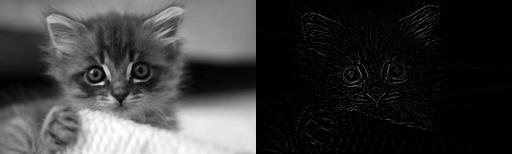

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

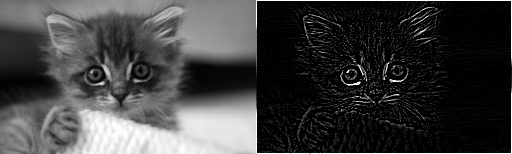

In [ ]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

#**Ejercicio 1**
Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?

**Prewitt**
* Kernel<br/>
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/89e0951634f88eb18d06923df71e89eb83e7fff3'/>
* Magnitude <br/>
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/23ae6772c5f58751fc6014b71d6adafb30a31c79'/>

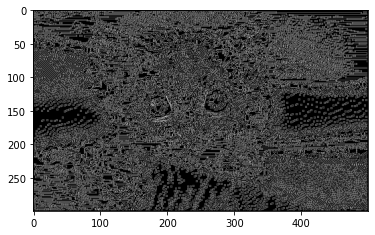

In [ ]:
# Prewitt Operator
# Fuente: https://en.wikipedia.org/wiki/Prewitt_operator

def prewitt(img):
  # kernels
  kx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
  ky = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

  # apply x-axis kernel
  gx = apply_filter(img, kx)
  # apply y-axis kernel
  gy = apply_filter(img, ky)

  # gradient magnitude
  J = np.sqrt((gx**2) + (gy**2))
  return J

  
J = prewitt(image)
plt.imshow(J, cmap='gray')
plt.show()

**Sobel**
* Kernel<br/>
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/848abd56e0e33cf402f01183bfe1f68a93fb34a9'/>
* Magnitude <br/>
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/23ae6772c5f58751fc6014b71d6adafb30a31c79'/>

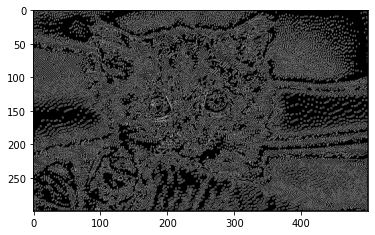

In [ ]:
# Sobel Operator
# Fuente: https://en.wikipedia.org/wiki/Sobel_operator

def sobel(img):
  # kernels
  kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
  ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

  # apply x-axis kernel
  gx = apply_filter(img, kx)
  # apply y-axis kernel
  gy = apply_filter(img, ky)

  # gradient magnitude
  J = np.sqrt((gx**2) + (gy**2))
  return J

J = sobel(image)
plt.imshow(J, cmap='gray')
plt.show()

**Laplace**
* Kernel<br/>
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/a58cb62fc6fb6a8ecf95edd1060c8a35d50963a4'/>


-4.0
4.0


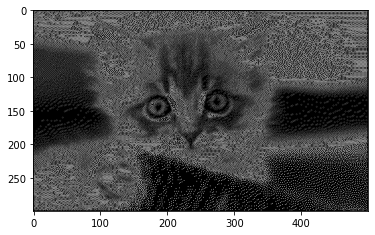

In [ ]:
# Laplace Operator
# Fuente: https://www.tutorialspoint.com/dip/laplacian_operator.htm

def laplace(img):
  # kernel
  k = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

  # apply kernel
  J = apply_filter(image, k)

  # check min and max values
  print(np.min(J))
  print(np.max(J))

  # enhance visibility
  alpha = 2
  J = J * alpha

  # remove values below 0 and/or above 255
  J[J < 0] = 0
  J[J > 255] = 255
  
  return J

J = laplace(image)
plt.imshow(J, cmap='gray')
plt.show()

#**Ejercicio 2**
*Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.*

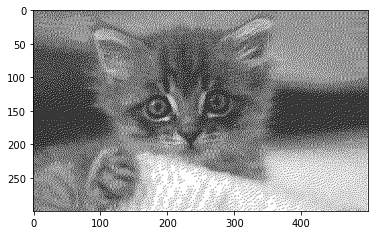

In [ ]:
J = prewitt(image)
alpha = 0.1
diff = image - J
result = image + alpha * diff

plt.imshow(result, cmap='gray')
plt.show()

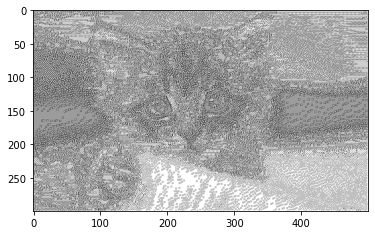

In [ ]:
J = prewitt(image)
alpha = 0.99
diff = image - J
result = image + alpha * diff

plt.imshow(result, cmap='gray')
plt.show()